Lossless compression algorithms are almost magical; you can take some data source squish it down into a smaller space, and then restore it back to its full size later.
They let us store and transfer large amounts of data for a fraction of the cost of the total data.
The algorithms aren't really magical though, they just exploit redundancies in the data like repeated substrings and some strings being used much more frequently than others.

For example suppose I need to store a large list of English words (maybe for a spell-checker, or a Scrabble or Wordle clone).
I could store the 26 letters of the English alphabet and an end of word symbol in 5 bit words from `00000` to `11010`.
Then given that an average word is about 5 letters I'll need about 25 bits per word.

However almost all my words have an `E`, in fact it makes almost 10% of my letters, and if I could use a shorter code for `E` (say `111`) then I could shrink the list considerably (by about 4%).
In fact if I could give the common letters like `E`, `T` and `A` all shorter codes, even if it means giving rare letters like `Q` and `Z` longer codes, then I could shrink the length of my list even more.

The Huffman Code gives the shortest possible average code length for a given symbol probability distribution.
It's used as part of many common compression algorithms such as in Zip files (via [Delfate](https://en.wikipedia.org/wiki/Deflate)), gzip, JPEG Images and MP3 Audio Files.
Despite it's utility it's actually quite straightforward and this article will show how to build the Huffman algorithm in Python.
If you want to understand the theory behind it I recommend Chapter 5 of [MacKay's *Information Theory, Inference, and Learning Algorithms*](http://www.inference.org.uk/itila/book.html) and the [Huffman Coding Wikipedia page](https://en.wikipedia.org/wiki/Huffman_coding).

## Optimal Symbol Codes

A *symbol code* takes each letter of our input alphabet and outputs a code, for example `A` could map to `00000` and `B` to `00001`.
To encode a string of symbols we just put their codes together, so `AB` would be `0000000001`.
Our goal is to create a code that has the fewest number of bits output on average.

This obviously depends on the distribution of the input symbols.
If we took an optimal symbol code for English, and then shifted all the letters by 1 (that is `A` becomes `B`, `B` becomes `C`, right through to `Z` becomes `A`) then the code would not be optimal for this new letter distribution.

The shortest possible code is less than 1 bit longer than the [*Shannon entropy*](https://en.wikipedia.org/wiki/Entropy_(information_theory)), $H$, of the underlying distribution.
Specifically if the input symbols have distribution $X$ then the minimum length is between $H(X)$ and $H(X)+1$ (see Theorem 5.1 of [MacKay](http://www.inference.org.uk/itila/book.html)).

In [1]:
from math import log2
from typing import List

def cross_entropy_bits(p: List[float], q: List[float]):
    if len(p) != len(q):
        raise ValueError("Lists must be equal length")

    return -sum(p_i * log2(q_i) for p_i, q_i in zip(p,q) if p_i != 0)

def entropy_bits(p: List[float]):
    return cross_entropy_bits(p, p)

Back to our English word list example if we look at the [distribution of English letters that Peter Norvig got from Google N-grams](https://norvig.com/mayzner.html), including the end of a word denoted by `_`:

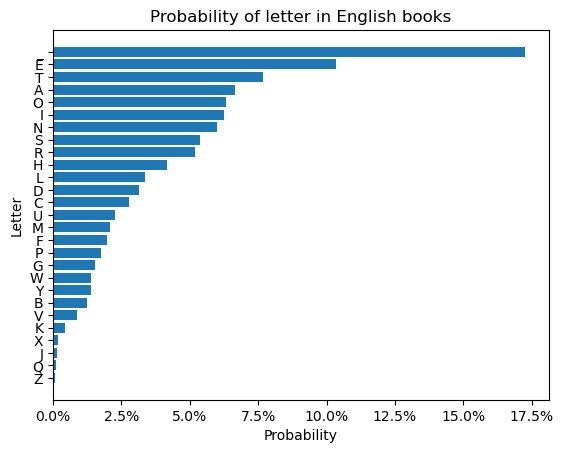

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# I've explicitly added a "space" here to determine the end of the word
letter_counts = dict(
_=743.8,E=445.2,T=330.5,A=286.5,O=272.3,I=269.7,N=257.8,
S=232.1,R=223.8,H=180.1,L=145.0,D=136.0,C=119.2,U=97.3,
M=89.5,F=85.6,P=76.1,G=66.6,W=59.7,Y=59.3,B=52.9,V=37.5,
K=19.3,X=8.4,J=5.7,Q=4.3,Z=3.2,
)

letter_probabilities = {k:v/sum(letter_counts.values()) for k,v in letter_counts.items()}

fig, ax = plt.subplots()
ax.barh(list(reversed(letter_probabilities.keys())),
         list(reversed(letter_probabilities.values())))
ax.set_title('Probability of letter in English books')
ax.set_xlabel('Probability')
ax.set_ylabel('Letter')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

Then the entropy is:

In [3]:
letter_entropy = entropy_bits(letter_probabilities.values())
letter_entropy

4.109986339934039

So the best compression ratio we could possibly have over our naive 5 bit encoding is:

In [4]:
f'{letter_entropy / 5:0.2%}'

'82.20%'

## Huffman Code

David Huffman's 1951 paper [A Method for the Construction of Minimum-Redundancy Codes](https://www.ias.ac.in/article/fulltext/reso/011/02/0091-0099) presented an algorithm for an optimal symbol code.
The idea is to build a binary tree by iteratively combining the two least probable items.
The code is then the path from the root of the tree to that item; improbable symbols have a very long code and probable symbols have a much shorter code.

![An example of a Binary Huffman Code](binary_coding.jpg)

## Binary Tree

We can implement the Huffman code in a straightforward (but not necessarily efficient) way in Python.

We start by defining the binary tree datastructure; we need a Leaf type that represents the input symbols and their probabilities (weights):

In [5]:
from dataclasses import dataclass
from typing import Any, Dict, Generic, List, Tuple, Generic, Mapping, Union, TypeVar

T = TypeVar('T')

@dataclass
class Leaf(Generic[T]):
    symbol: T
    weight: float

And an InternalNode type that consists of a pointer to two other objects, either a Leaf or another Node.
Their weight is precisely the sum of the weights of the two children.

In [6]:
@dataclass
class InternalNode(Generic[T]):
    left: Union[Leaf, 'Node[T]']
    right: Union[Leaf, 'Node[T]']
    weight: float

A Node represents either a Leaf or an InternalNode:

In [7]:
Node = Union[Leaf[T], InternalNode[T]]

## Iteration Step

We start off with a list of Leaf Nodes, and then at each step combine the two smallest weight Nodes to produce a new Node.
This continues until there is only one Node left.

First we need a procedure to find the two smallest Nodes:

In [8]:
def smallest_two_indices(l: List[float]) -> Tuple[int, int]:
    if len(l) < 2:
        raise ValueError("Requires at least two items")
    
    result = []
    indices = list(range(len(l)))

    idx_smallest = min(indices, key=lambda i: l[i])
    idx_second_smallest = min((i for i in indices if i != idx_smallest),
                              key=lambda i: l[i])
    
    return idx_smallest, idx_second_smallest

Note this is by no means the most efficient way to do this since we scan through the whole list twice when we could do it in a single scan.
In fact if we first sorted the nodes and kept them in sorted order (with a [priority queue](https://en.wikipedia.org/wiki/Priority_queue) like [heapq](https://docs.python.org/3/library/heapq.html)) we could reduce the cost of the whole algorithm from $O(N^2)$ to $O(N \log N)$ where $N$ is the number of source symbols.
To keep things simple I won't do this here.

We can check this implementation returns the indices of the two smallest values using [property based testing](/property-based-testing) with [hypothesis](https://hypothesis.readthedocs.io/en/latest/):

In [9]:
from hypothesis import given
import hypothesis.strategies as st

@given(st.lists(st.floats(allow_nan=False), min_size=2))
def test_smallest_two_indices(l):
    smallest_idx, second_smallest_idx = smallest_two_indices(l)
    smallest_value, second_smallest_value = l[smallest_idx], l[second_smallest_idx]

    for idx, value in enumerate(l):
        assert smallest_value <= value

        if idx != smallest_idx:
            assert second_smallest_value <= value


test_smallest_two_indices()

Then in each step we take a list of Nodes of length $L>1$ and combine the two smallest nodes to get an output list of length $L-1$.
The sum of the weights is invariant in each step.

In [10]:
# Contract: len(components) > 1
#           len(components) + 1 == len(return)
#           sum(c.probability for c in components) = sum(r.probability for r in return)
def huffman_step(components: List[Node[T]]) -> List[Node[T]]:
    idx0, idx1 = smallest_two_indices([l.weight for l in components])

    left = components[idx0]
    right = components[idx1]

    node = InternalNode(left=left, right=right, weight = left.weight + right.weight)

    result = [node] + [components[idx] for idx in range(len(components)) if idx != idx0 and idx != idx1]
    assert len(result) + 1 == len(components)
    return result

Then to build the Huffman Tree is a simple matter of applying this step recursively until we only have a single root node left.

In [11]:
def huffman_tree(scores: Mapping[Any, float]) -> Node:
    components = [Leaf(symbol=k, weight=v) for k,v in scores.items()]
    while len(components) > 1:
        components = huffman_step(components)
    return components[0]

## Getting the code

To get the code from the tree we need to walk the tree and output the path codes to each node.

Let's start with a concrete example; suppose we have a source with these probabilities:

In [12]:
probs = dict(
    a=0.25,
    b=0.25,
    c=0.2,
    d=0.15,
    e=0.15,
)

We can then create the tree:

In [13]:
tree = huffman_tree(probs)
tree

InternalNode(left=InternalNode(left=Leaf(symbol='c', weight=0.2), right=Leaf(symbol='a', weight=0.25), weight=0.45), right=InternalNode(left=Leaf(symbol='b', weight=0.25), right=InternalNode(left=Leaf(symbol='d', weight=0.15), right=Leaf(symbol='e', weight=0.15), weight=0.3), weight=0.55), weight=1.0)

Unless you're a Lisp afficianado this tree might be hard to visualise; but we can easily draw it out with `graphviz`:

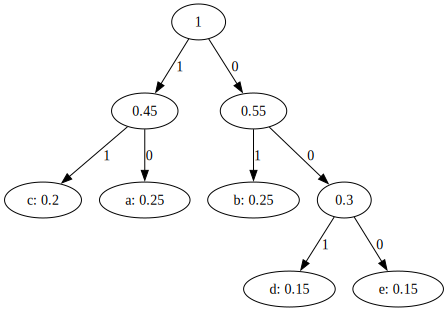

In [14]:
import graphviz

def show_tree_inner(node: Node, graph: graphviz.Digraph, path: str, weight_format):
    if isinstance(node, Leaf):
        graph.node(path, ('%s: ' + weight_format) % (node.symbol, node.weight))
    else:
        graph.node(path, (weight_format % node.weight))

        show_tree_inner(node.left, graph, path+'1', weight_format=weight_format)
        show_tree_inner(node.right, graph, path+'0', weight_format=weight_format)
        graph.edge(path, path+'1', label='1')
        graph.edge(path, path + '0', label='0')
        
def show_tree(node: Node, weight_format='%0.6g') -> graphviz.Digraph:
    graph = graphviz.Digraph()
    show_tree_inner(node, graph, '', weight_format=weight_format)
    return graph

graph = show_tree(tree)
graph

We can read out the paths by walking down the tree depth first, keeping track of the path to the current node:

In [15]:
def tree_to_code_inner(node: Node[T], code: Dict[T, str], path: str = ''):
    if isinstance(node, Leaf):
        assert node.symbol not in code, "Duplicate symbol %s" % node.symbol
        code[node.symbol] = path
    else:
        tree_to_code_inner(node.left, code, path + '1')
        tree_to_code_inner(node.right, code, path + '0')

def tree_to_code(node: Node[T]) -> Dict[T, str]:
    code = dict()
    tree_to_code_inner(node, code)
    return code
    

code = tree_to_code(tree)
code

{'c': '11', 'a': '10', 'b': '01', 'd': '001', 'e': '000'}

The expected length is close to the entropy bounds:

In [16]:
probs_entropy = entropy_bits(probs.values())
probs_entropy

2.2854752972273342

In [17]:
expected_length = sum(probs[s] * len(code[s]) for s in probs)

assert probs_entropy <= expected_length < probs_entropy + 1

expected_length

2.3

## Checking the properties in general

Let's run some sanity Property Based Tests that our code is correct.

We can first convert a weight map straight to a code, hiding the intermediate tree.
Note there is nothing in the algorithm that requires the weights to be probabilities; and in fact you get the same tree under any positive rescaling.

In [18]:
def huffman_code(weight: Mapping[T, str]) -> dict[T, str]:
    return tree_to_code(huffman_tree(weight))

The output dictionary should have the exact same keys as the input dictionary:

In [19]:
@given(st.lists(st.floats(min_value=0, allow_nan=False, allow_infinity=False, allow_subnormal=False), min_size=1))
def test_huffman_code_preserves_symbols(weights):
    symbol_weights = dict(enumerate(weights))
    code = huffman_code(symbol_weights)
    assert set(symbol_weights) == set(code)
test_huffman_code_preserves_symbols()

It's also also within the entropy bounds (as long as we don't run into floating point errors):

In [20]:
@given(st.lists(st.floats(min_value=1.0, max_value=1e5, allow_nan=False, allow_infinity=False, allow_subnormal=False), min_size=1))
def test_huffman_code_in_entropy_bounds(weights):
    symbol_weights = dict(enumerate(weights))
    code = huffman_code(symbol_weights)

    total = sum(weights)
    probs = [w/total for w in weights]
    
    model_entropy = entropy_bits(probs)
    
    expected_length = sum(probs[i] * len(code[i]) for i in range(len(weights)))

    assert model_entropy <= expected_length < model_entropy + 1, (model_entropy, expected_length)

test_huffman_code_in_entropy_bounds()

Finally it's important to note that the code is a *prefix code*, where no code word is the prefix of any other keyword.
Consider if `A` has code `0` and `B` has code `00`, then it is unclear whether `00` means `AA` or `B`.
For a prefix code we can read the bits until we find the first matching code word and can guarantee that was the input symbol (because if we keep reading we'll never match another symbol).
Huffman codes are a prefix code because they are the leaves of a tree; non-prefix nodes are the internal nodes of the tree.

In [21]:
from typing import List

def is_prefix(a: str, b: str):
    return a.startswith(b)

def is_prefix_code(codes: List[str]):
    for i in range(len(codes)):
        for j in range(i+1, len(codes)):
            if is_prefix(codes[i], codes[j]) or is_prefix(codes[j], codes[i]):
                return False
    return True

assert is_prefix_code(['0', '10', '110', '111'])
assert not is_prefix_code(['0', '00'])

We can explicity test this for Huffman Codes.

In [22]:
@given(st.lists(st.floats(min_value=0, allow_nan=False, allow_infinity=False, allow_subnormal=False), min_size=1))
def test_huffman_code_is_prefix_code(weights):
    symbol_weights = dict(enumerate(weights))
    code = huffman_code(symbol_weights)

    assert is_prefix_code(list(code.values()))

test_huffman_code_is_prefix_code()

## Example English Word List

Before we wanted to encode an English word list and worked out the shortest average length we could possibly get is:

In [23]:
entropy_bits(letter_probabilities.values())

4.109986339934039

We can look at the codewords from our Huffman Code, their length, and the probability times their length:

In [24]:
import pandas as pd

letter_code = huffman_code(letter_probabilities)

df_letter = (
    pd.DataFrame(data=dict(probability=letter_probabilities.values(),
                           code_word=[letter_code[s] for s in letter_probabilities],),
                 index=letter_probabilities.keys())
    .assign(code_length=lambda _:_.code_word.str.len())
    .assign(probability_times_length=lambda _:_.code_length * _.probability)
)
df_letter

,probability,code_word,code_length,probability_times_length
_,0.172680,000,3,0.518039
E,0.103357,110,3,0.310071
T,0.076728,0010,4,0.306914
A,0.066513,0100,4,0.266054
O,0.063217,0110,4,0.252867
I,0.062613,0111,4,0.250453
N,0.059850,1000,4,0.239402
S,0.053884,1010,4,0.215536
R,0.051957,1011,4,0.207828
H,0.041812,1111,4,0.167247


The average length is pretty close to the Entropy bound:

In [25]:
average_length = sum(df_letter['probability_times_length'])
average_length

4.14075776570553

And so the compression ratio of this code would be:

In [26]:
f'{average_length / 5:0.1%}'

'82.8%'

## Worst Case: Rare Symbols

Consider a case where you have only two symbols with very uneven probabilities:

In [27]:
rare_probabilities = dict(
    a=0.95,
    b=0.05,
)

The entropy is very low here since most of the time we will get `a`:

In [28]:
entropy_bits(rare_probabilities.values())

0.28639695711595625

But since we only have two symbols all we can do is assign 1-bit codes to each of them

In [29]:
rare_code = huffman_code(rare_probabilities)
rare_code

{'b': '1', 'a': '0'}

And the expected length is clearly 1:

In [30]:
sum(len(rare_code[s]) * rare_probabilities[s] for s in rare_probabilities)

1.0

### Block Codes

One workaround for this is *block codes* where we encode blocks of symbols rather than individual symbols.
For example for a block of length 2 it would look like:

In [31]:
block2_probabilities = {}

for s1, p1 in rare_probabilities.items():
    for s2, p2 in rare_probabilities.items():
        block2_probabilities[s1 + s2] = p1 * p2

block2_probabilities

{'aa': 0.9025, 'ab': 0.0475, 'ba': 0.0475, 'bb': 0.0025000000000000005}

Since we have assumed the frequencies are independent the entropy doubles:

In [32]:
entropy_bits(block2_probabilities.values())

0.5727939142319123

But now we can assign a shorter sequence to the very probable sequence `aa` to the very improbable sequence `ab`:

In [33]:
block2_code = huffman_code(block2_probabilities)
block2_code

{'ba': '11', 'bb': '101', 'ab': '100', 'aa': '0'}

But the expected length is still necessarily greater than 1, and much greater than the entropy.

In [34]:
sum(len(block2_code[s]) * block2_probabilities[s] for s in block2_probabilities)

1.1475

As we make the blocks larger the length gets closer to the ideal length (but the symbol dictionary grows exponentially):

In [35]:
block4_probabilities = {}

for s1, p1 in block2_probabilities.items():
    for s2, p2 in block2_probabilities.items():
        block4_probabilities[s1 + s2] = p1 * p2

entropy_bits(block4_probabilities.values())

1.1455878284638241

In [36]:
block4_code = huffman_code(block4_probabilities)
block4_code

{'aaba': '111',
 'abaa': '110',
 'baaa': '101',
 'bbaa': '100111',
 'babb': '100110111',
 'bbab': '100110110',
 'bbba': '100110101',
 'bbbb': '1001101001',
 'abbb': '1001101000',
 'abab': '1001100',
 'abba': '1001011',
 'baab': '1001010',
 'baba': '1001001',
 'aabb': '1001000',
 'aaab': '1000',
 'aaaa': '0'}

In [37]:
sum(len(block4_code[s]) * block4_probabilities[s] for s in block4_probabilities)

1.4687625000000002

# Practical Example: WikiText

Let's now see how we could use a Huffman code in practice to compress a sample of English Wikipedia as in [the Hutter Prize](http://prize.hutter1.net/).

First we download the 35MB `enwik8.zip` file containing the first million bytes of an XML dump of English wikipedia.

In [38]:
from urllib.request import urlretrieve
from zipfile import ZipFile

urlretrieve('http://mattmahoney.net/dc/enwik8.zip', filename='enwik8.zip')

('enwik8.zip', <http.client.HTTPMessage at 0x7ee0bff533d0>)

Then to keep the code a bit simpler let's read it all into memory:

In [39]:
with ZipFile('enwik8.zip').open('enwik8') as f:
    enwiki8 = f.read()

print(enwiki8[:500])

b'<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.3/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.3/ http://www.mediawiki.org/xml/export-0.3.xsd" version="0.3" xml:lang="en">\n  <siteinfo>\n    <sitename>Wikipedia</sitename>\n    <base>http://en.wikipedia.org/wiki/Main_Page</base>\n    <generator>MediaWiki 1.6alpha</generator>\n    <case>first-letter</case>\n      <namespaces>\n      <namespace key="-2">Media</namespace>\n      <n'


Since this is a byte string, and a byte is 8 bits, the total length of the uncompressed file in bits is:

In [40]:
len(enwiki8) * 8

800000000

We can treat the text as a sequence of bytes, that is the symbols are in the range 0-255.
To get estimates of the probabilities we can simply count the frequencies (being careful to include bytes that don't appear):

In [41]:
from collections import Counter

counts = Counter({i:0 for i in range(256)})
counts.update(enwiki8)
counts.most_common(10)

[(32, 13519824),
 (101, 8001205),
 (116, 6154908),
 (97, 5712026),
 (105, 5227649),
 (111, 5176143),
 (110, 4909103),
 (114, 4506880),
 (115, 4347421),
 (108, 3047318)]

Using this unigram language model on the bytes we can calculate the entropy, to get a little over 5 bits per byte:

In [42]:
probs = {k: v/counts.total() for k,v in counts.items()}

entropy_bits(probs.values())

5.080140303348569

Since our source uses 8 bits per byte the best compression ratio we could expect is

In [43]:
f'{entropy_bits(probs.values())/8:0.1%}'

'63.5%'

We can use the counts to generate the Huffman Code (since they are proportional to the probabilities it gives the same tree as the probabilities).

In [44]:
enwiki8_code = huffman_code(counts)

assert is_prefix_code(enwiki8_code)

enwiki8_code[32]

'010'

The expected length is just a little over the entropy:

In [45]:
expected_length = sum(probs[i] * len(enwiki8_code[i]) for i in probs)
expected_length

5.108938110000002

Giving an actual compression of

In [46]:
f'{expected_length/8:0.1%}'

'63.9%'

## Storing the codebook

If we actually wanted to decode this we would need the Huffman code itself as well as the encoded string.
One way to store this variable length code is to store, in order, the number of output bits for each symbol followed by the symbol itself (there are almost surely more efficient representations; since we know it is a prefix code there must be redundancy).

Since the maximum symbol length is less than the size of the alphabet (here 256) we can store the length in a single byte.

In [47]:
from math import ceil

num_symbols = 256

num_symbol_bytes = ceil(log2(num_symbols-1))
num_symbol_bytes

length_symbol_format = f'0{num_symbol_bytes}b'
length_symbol_format

'08b'

In [48]:
def codebook_encode_symbol(codeword: str) -> str:
    return format(len(codeword), length_symbol_format) + codeword


codebook_encode_symbol('010')

'00000011010'

In [49]:
def codebook_decode_symbol(symbols: str, position: int = 0) -> Tuple[str, int]:
    codeword_length = int(symbols[position:position+num_symbol_bytes], 2)
    position += 8
    codeword = symbols[position:position+codeword_length]
    return codeword, position+codeword_length

codebook_decode_symbol(codebook_encode_symbol('010'))

('010', 11)

We can now write the entire codebook; in this case it takes around 7kb, very small compared to the file we are compressing:

In [50]:
def codebook_encode(code) -> str:
    return ''.join([codebook_encode_symbol(code[i]) for i in range(num_symbols)])

enwiki8_code_str = codebook_encode(enwiki8_code)
len(enwiki8_code_str)

7020

In [51]:
def codebook_decode(code_str: str) -> Tuple[dict[int, str], int]:
    code = {}
    position = 0
    for i in range(num_symbols):
        code[i], position = codebook_decode_symbol(code_str, position)
    return code, position

In [52]:
enwiki8_code_2, position = codebook_decode(enwiki8_code_str)

assert position == len(enwiki8_code_str)
assert enwiki8_code_2 == enwiki8_code

## Storing the whole code

We can now compress the whole text along with the code, getting the compression rate we predicted:

In [53]:
enwiki8_compressed = ''.join([enwiki8_code_str] + [enwiki8_code[i] for i in enwiki8])

f'{len(enwiki8_compressed) / (8*len(enwiki8)):0.1%}'

'63.9%'

To decode it first read the codebook:

In [54]:
codebook, start_pos = codebook_decode(enwiki8_compressed)

In [55]:
inverse_codebook = {v:k for k,v in codebook.items()}

Let's store it in order of increasing length so the most likely items are encountered first.

In [56]:
codebook = dict(sorted(codebook.items(), key=lambda i: len(i[1])))

Then we can go through and decode the items one-by-one.

This is pretty slow because we're doing a bunch of unnecesary work:

* rescanning the whole key set each time in increasing length (we only need to check keys of a given length)
* re-reading all the bits of each codeword multiple times
* checking strings of length not in the codebook
* representing bit strings as unicode strings
* running in Python

In [57]:
position = start_pos
enwiki8_decompressed = []

while position < len(enwiki8_compressed):
    for code_length in range(1, num_symbols):
        next_codeword = enwiki8_compressed[position:position+code_length]
        if next_codeword in inverse_codebook:
            position += code_length
            enwiki8_decompressed.append(inverse_codebook[next_codeword])
            break
    else:
        raise ValueError("Can't find prefix")

enwiki8_decompressed = bytes(enwiki8_decompressed)
assert enwiki8_decompressed == enwiki8

## Block Encodings

We saw earlier that block encodings are useful when there are independent terms far from the entropy bound.
They are also useful when there are dependencies between symbols; in English after a `t` the most likely letter is an `h`.
This more informative model then has a lower entropy.

For example our letter-wise model had an entropy in bits per byte of:

In [58]:
entropy_bits(probs.values())

5.080140303348569

Consider if instead we encoded *pairs* of letters:

In [59]:
enwiki8_pair_counts = Counter(zip(enwiki8[::2], enwiki8[1::2]))

enwiki8_pair_counts.most_common(10)

[((101, 32), 985464),
 ((32, 116), 712370),
 ((116, 104), 677395),
 ((115, 32), 660026),
 ((104, 101), 621682),
 ((32, 97), 594513),
 ((105, 110), 581426),
 ((101, 114), 569153),
 ((97, 110), 537148),
 ((110, 32), 509035)]

We then get a lower entropy in bits/byte (remembering that each symbol is now a pair of 1 byte charaters):

In [60]:
pair_total = enwiki8_pair_counts.total()
pair_probs = {k: v/pair_total for k,v in enwiki8_pair_counts.items()}

entropy_bits(pair_probs.values()) / 2

4.482906292674593

We can construct the optimal code and check we get something very close to this:

In [61]:
pair_code = huffman_code(pair_probs)

expected_pair_length = sum(pair_probs[ij] * len(pair_code[ij]) for ij in pair_code) / 2
expected_pair_length

4.497371490000442

Giving a compression ratio of

In [62]:
f'{expected_pair_length / 8:0.1%}'

'56.2%'

However our code book is now *much bigger* and will take more memory to store:

In [63]:
f'{len(enwiki8_pair_counts):_}'

'16_976'

We can continue this to triplets of letters:

In [64]:
enwiki8_triple_counts = Counter(zip(enwiki8[::3], enwiki8[1::3], enwiki8[2::3]))

enwiki8_triple_counts.most_common(10)

[((32, 116, 104), 325585),
 ((116, 104, 101), 303660),
 ((104, 101, 32), 288105),
 ((32, 91, 91), 215060),
 ((32, 32, 32), 204278),
 ((32, 111, 102), 168972),
 ((111, 102, 32), 161487),
 ((101, 100, 32), 147227),
 ((97, 110, 100), 139953),
 ((32, 97, 110), 133823)]

The entropy is slightly lower again:

In [65]:
triple_total = enwiki8_triple_counts.total()
triple_probs = {k:v/triple_total for k,v in enwiki8_triple_counts.items()}

entropy_bits(triple_probs.values()) / 3

4.016664778438732

But our codebook is now huge:

In [67]:
f'{len(enwiki8_triple_counts):_}'

'173_479'

At some point the size of the codebook becomes larger than the file we are trying to compress and we need a different approach.

## What next

Symbol codes are a useful tool but they don't take into account multi-symbol patterns, and in particular *repetition* in the data.
Effective compression programs first apply a pattern dependent compression, such as a variant of [Lempel-Ziv Compression](https://en.wikipedia.org/wiki/LZ77_and_LZ78) before applying a Huffman encoding.